<a id='sec0'></a>
# Predictive annotation of quantification methods with Noun Chunks
Idea is to use the descriptive text for each dataset to predict which quantification method was used for the experiments for the dataset. Below is an outline for the process.<br>
- <a href='#sec1'><b>Data preparation</b></a>
- <a href='#sec2'><b>NLP</b></a>
- <a href='#sec3'><b>Classification (Initial)</b></a>
- <a href='#sec4'><b>Classification (Deeper)</b></a>

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import spacy

from nltk.corpus import stopwords
from gensim import corpora, models
from gensim import matutils
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
        accuracy_score, precision_score, recall_score,
        average_precision_score, f1_score,
        brier_score_loss, classification_report,
        precision_recall_curve, roc_auc_score, roc_curve)

<a id='sec1-1'></a>
#### 1. Read in data and process df

In [3]:
with open('nlp15_data/dfs/all_fields_nchunks_df_quant_dummies.pickle', 'rb') as infile_df:
    df = pickle.load(infile_df)

protocols_tfidf = corpora.MmCorpus('nlp15_data/bow_and_tfidf/protocols_tfidf_nchunks.mm')
whole_tfidf = corpora.MmCorpus('nlp15_data/bow_and_tfidf/whole_tfidf_nchunks.mm')

my_dictionary = corpora.Dictionary.load('nlp15_data/whole_dictionary_nchunks.dict')
print(my_dictionary)

Dictionary(125116 unique tokens: [') luminal a tumors', '1 tumors', '24 lymph node', '24 lymph node negative grade 1 luminal a primary breast tumors', '4405 proteins']...)


In [4]:
df.head(2)

,dataset_id,sample_protocol,data_protocol,description,instruments,exp_types,quant_methods,labhead_fullname,silac,ms1_label_free,spectrum_counting,tmt,itraq,label_free
0,PXD000029,"[breast cancer tissue lysates, reduction, alky...","[proteomics data, proteome discoverer, fdr<0.0...","[current prognostic factors, precise risk-disc...",LTQ Orbitrap Velos,Shotgun proteomics,itraq,Pavel Bouchal,0,0,0,0,1,0
1,PXD000164,"[protein extraction, catheter biofilm small pi...","[tryptic digest, reversed phase, rp) chromatog...","[term-catheterization, catheter-associated bac...",LTQ Orbitrap Velos,Shotgun proteomics,label free,Katharina Riedel,0,0,0,0,0,1


In [5]:
len(df), len(protocols_tfidf), len(whole_tfidf)

(2387, 2387, 2387)

<a id='sec3'></a>
## Classification (initial)
<a href='#sec0'>(Back to top)</a><br><br>
<i>Here, I'll focus on binary classification for each category. For example, one task would be to distinguish 'silac' from everything else. Ideally, it should be multi-class classification, but since a dataset can contain multiple quantification methods, for now, I'll stick with yes/no type binary classification for each quantification method that I picked. Here, I'll use Tf-Idf vectors only and take a quick look at the performance of different classifiersvisually with ROC curves. </i><br>
<br>
Classifiers to try: MultinomialNB, Logistic Regression, Random Forest (and SVM maybe?)<br>
<br>
For each classifier for each text set for each type of word vectors for each quantification type:
1. Split into train/test with a fixed random_state for comparison
2. Run vanilla classifier without much hyperparameter tuned and plot ROC curves

#### Loading data

In [9]:
def classify(corpus, target, num_terms=22736, test_size=0.2, random_state=777):
    # Set features and y
    x = matutils.corpus2dense(corpus, num_terms=num_terms).T
    y = np.array(target)
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    
    # Classifiers to test
    classifiers = {
    'MultinomialNB': MultinomialNB(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_jobs=8)
    }

    results = {}
    for name, clf in classifiers.items():
        result = {}
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)
        report = classification_report(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        result['report'] = report
        result['fpr'] = fpr
        result['tpr'] = tpr
        results[name] = result
    return results


def multiple_classify(my_corpora, target, target_labe=None, num_terms=22736, test_size=0.2, random_state=777):
    fig = plt.figure(figsize=(12, 8))
    t = np.linspace(0, 1, 10)
    ax_pos = 1

    for corpus_name, corpus in my_corpora.items():
        results = classify(corpus, target, num_terms=num_terms)

        ax = fig.add_subplot(2, 3, ax_pos)
        ax.plot(t, t, ls='--', lw=0.5, color='0.4')
        for k, v in results.items():
            #print('='*5, 'Report for %s' % k, '='*10)
            #print(v['report'])
            fpr = v['fpr']
            tpr = v['tpr']
            ax.plot(fpr, tpr, label=k)
        ax.legend()
        ax.set_xlabel('False Positive Rate')#, fontsize=14)
        ax.set_ylabel('True Positive Rate')#, fontsize=14)
        a = ax.set_title('Annotating \'%s\'\nby %s' % (target_labe, corpus_name))#, fontsize=14)
        ax_pos += 1

    fig.tight_layout()

In [10]:
my_corpora = {
    'protocols': protocols_tfidf,
    'all_combined': whole_tfidf
}

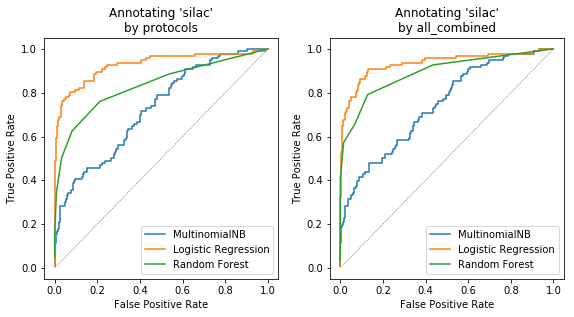

In [11]:
multiple_classify(my_corpora, df.silac, target_labe='silac', num_terms=125116, test_size=0.2, random_state=777)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


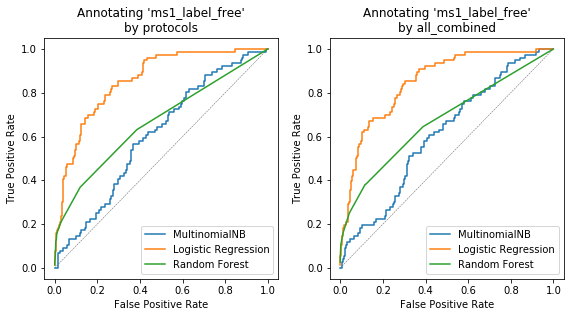

In [12]:
multiple_classify(my_corpora, df.ms1_label_free, target_labe='ms1_label_free', num_terms=125116, test_size=0.2, random_state=777)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


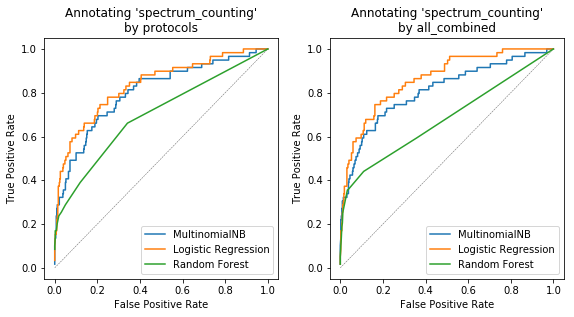

In [13]:
multiple_classify(my_corpora, df.spectrum_counting, target_labe='spectrum_counting', num_terms=125116, test_size=0.2, random_state=777)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


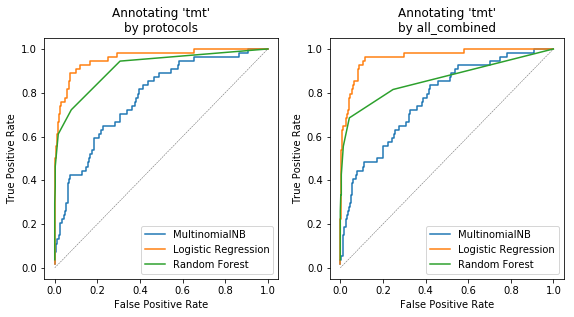

In [14]:
multiple_classify(my_corpora, df.tmt, target_labe='tmt', num_terms=125116, test_size=0.2, random_state=777)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


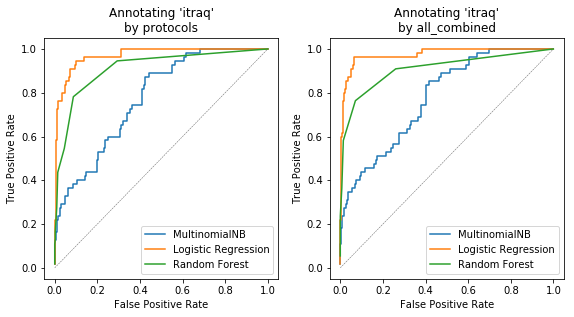

In [15]:
multiple_classify(my_corpora, df.itraq, target_labe='itraq', num_terms=125116, test_size=0.2, random_state=777)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


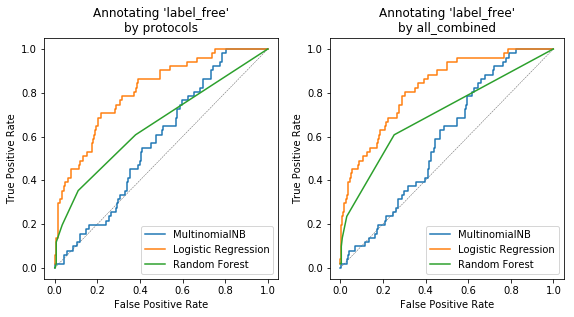

In [16]:
multiple_classify(my_corpora, df.label_free, target_labe='label_free', num_terms=125116, test_size=0.2, random_state=777)

<i>They actually look very good though the prediction process is quite quick and dirty! It appears combination of sample- and data-processing protocols, as well as its combination with the description field, perform well. As for the classifiers, Naive Bayes performed quite poorly, while Logistic Regression performed best. I can focus on LR and do proper CV and assessements next. Here, all the words were used (i.e. num_terms=(number of unique tokens in the dictionary)), however, that is quite likely unnecessary so columns should be systematically eliminated. Hyperparameters will be tuned too.</i>

<a id='sec4'></a>
## Classification (deeper dig)
<a href='#sec0'>(Back to top)</a><br><br>
Looks like automatic annotation is quite possible for most quantification methods! 'Description' appear not so useful as the protocol fields. Here I'll focus on both_protocols corpora (and maybe whole_corpus too) and assess the classification more properly.<br>
<br>
Classifiers to use: Logistic Regression and Ramdom Forest<br>
Class label: Only try on 'silac' here
<br>
For each classifier for each text set for each type of word vectors for each quantification type:<br>
1. Put features and target labels in 4~5 CV fold
2. Run vanilla classifier without much hyperparameter tuned and collect:
    - accuracy
    - precision, recall, & F1
    - precision_recall curve
    - average_precision_score
    - fpr, tpr, roc_curve, roc_auc
    - brier loss
3. Tabulate and plot results

In [ ]:
def classifyCV(clf, corpus, target, name=None, n_splits=5, num_terms=22736):
    # Set features and y
    if type(corpus) == np.ndarray:    # This is just for convenience later. Not a good coding design though.
        X = corpus
    else:
        X = matutils.corpus2dense(corpus, num_terms=num_terms).T
    y = np.array(target)
    
    # Cross Validation Loop
    kf = KFold(n_splits=n_splits)
    results = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        
        # create result dictionary
        result = {}
        result['classifier'] = name

        # Fit a model and predict
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)
        
        # Get metrics
        result['CV_fold'] = n_splits
        result['accuracy'] = accuracy_score(y_test, y_pred)
        result['precision'] = precision_score(y_test, y_pred)
        result['recall'] = recall_score(y_test, y_pred)
        result['average_precision'] = average_precision_score(y_test, y_proba[:, 1])
        result['Brier_loss'] = brier_score_loss(y_test, y_proba[:, 1])
        result['f1'] = f1_score(y_test, y_pred)

        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        result['fpr'] = fpr
        result['tpr'] = tpr
        result['roc_auc'] = roc_auc_score(y_test, y_proba[:, 1])
        
        precision_, recall_, _ = precision_recall_curve(y_test, y_proba[:, 1])
        result['precision_vals'] = precision_
        result['recall_vals'] = recall_

        results.append(result)
            
    results = pd.DataFrame(results)
    
    return results

def get_stats(results, label):
    col = results[label]
    mean = col.mean()
    std = col.std()
    print('%s: %.2f +/- %.3f' % (label, mean, std))
    return

def summarize_results(results, clf_label='', target_label='', plot_result=True):
    score_cols = [
        'accuracy',
        'precision',
        'recall',
        'f1',
        'average_precision',
        'roc_auc',
        'Brier_loss',
    ]
    print('='*10, '%s %d-fold CV stats' % (clf_label, len(results)), '='*10)
    for col in score_cols:
        get_stats(results, col)
    
    if plot_result:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        for i in range(len(results)):
            fpr = results.fpr.iloc[i]
            tpr = results.tpr.iloc[i]
            ax1.plot(fpr, tpr, label=('CV %d' % (i+1)))
            ax1.set_xlabel('False Positive Rate')
            ax1.set_ylabel('True Positive Rate')
            ax1.set_title('ROC: Logistic Regr. (\'%s\')' % target_label)
            ax1.legend()

            precision_vals = results.precision_vals.iloc[i]
            recall_vals = results.recall_vals.iloc[i]
            ax2.plot(recall_vals, precision_vals, label=('CV %d' % (i+1)))
            ax2.set_xlabel('Recall')
            ax2.set_ylabel('Precision')
            ax2.set_title('Precision-Recall: Logistic Regr. (\'%s\')' % target_label)
            ax2.legend()

        fig.tight_layout()
    return

In [ ]:
silac_results = classifyCV(LogisticRegression(), protocols_tfidf, df.silac,
    name='Logistic Regression', n_splits=10, num_terms=22736)
summarize_results(silac_results, clf_label='Logistic Regression', target_label='silac')

In [ ]:
whole_results = classifyCV(LogisticRegression(), whole_tfidf,  df.silac,
                                name='Logistic Regression', n_splits=10, num_terms=22736)
summarize_results(whole_results, clf_label='Logistic Regression', target_label='silac')

<i>Try L1 regularization instead of L2 (which is default)</i>

In [ ]:
clf1 = LogisticRegression(penalty='l1')
silac_results = classifyCV(clf1, protocols_tfidf, df.silac,
    name='Logistic Regression', n_splits=10, num_terms=22736)
summarize_results(silac_results, clf_label='Logistic Regression', target_label='silac')

<i>Decrease regularization strength (C value)</i>

In [ ]:
clf2 = LogisticRegression(penalty='l1', C=1000)
silac_results = classifyCV(clf1, protocols_tfidf, df.silac,
    name='Logistic Regression', n_splits=10, num_terms=22736)
summarize_results(silac_results, clf_label='Logistic Regression', target_label='silac')

<i>No fitting of intercept</i>

In [ ]:
clf2 = LogisticRegression(penalty='l1', fit_intercept=False)
silac_results = classifyCV(clf1, protocols_tfidf, df.silac,
    name='Logistic Regression', n_splits=10, num_terms=22736)
summarize_results(silac_results, clf_label='Logistic Regression', target_label='silac')

<i>L1 seems to eliminate some unnecessary features and improve the recall. Try removing columns first by Random Forest and the try again with smaller feature</i>

#### Feature Selection

In [ ]:
rfc = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=8)
silac_results = classifyCV(rfc, protocols_tfidf, df.silac,
    name='Logistic Regression', n_splits=5, num_terms=22736)
summarize_results(silac_results, clf_label='Logistic Regression', target_label='silac')

In [ ]:
# Get number of non-zero features
rfc.n_features_, np.count_nonzero(rfc.feature_importances_)

In [ ]:
pd.Series(rfc.feature_importances_).describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

In [ ]:
h = plt.hist(rfc.feature_importances_, bins=500)
plt.ylim([0, 200])

In [ ]:
X0 = matutils.corpus2dense(protocols_tfidf, num_terms=22736).T

new_inds1 = np.argwhere(rfc.feature_importances_ >= 0.001).flatten()
new_inds2 = np.argwhere(rfc.feature_importances_ >= 0.005).flatten()
new_inds3 = np.argwhere(rfc.feature_importances_ >= 0.01).flatten()

X1 = X0[:, new_inds1]
X2 = X0[:, new_inds2]
X3 = X0[:, new_inds3]

print('Shape before:', X0.shape)
print('Shape X1   :', X1.shape)
print('Shape X2   :', X2.shape)
print('Shape X3   :', X3.shape)

In [ ]:
# Check fraction of silac class
print('Fraction with silac = %.2f%%' % (100*df.silac.sum()/len(df)))

##### With RFC

In [ ]:
rfcX1 = RandomForestClassifier(max_depth=5, n_estimators=10, n_jobs=8)
rfcX2 = RandomForestClassifier(max_depth=5, n_estimators=10, n_jobs=8)
rfcX3 = RandomForestClassifier(max_depth=5, n_estimators=10, n_jobs=8)

res_X1 = classifyCV(rfcX1, X1, df.silac, name='RFC', n_splits=10, num_terms=22736)
res_X2 = classifyCV(rfcX2, X2, df.silac, name='RFC', n_splits=10, num_terms=22736)
res_X3 = classifyCV(rfcX3, X3, df.silac, name='RFC', n_splits=10, num_terms=22736)

In [ ]:
summarize_results(res_X1, clf_label='RFC with X1', target_label='silac', plot_result=True)
summarize_results(res_X2, clf_label='RFC with X2', target_label='silac', plot_result=True)
summarize_results(res_X3, clf_label='RFC with X3', target_label='silac', plot_result=True)

#### With LR

In [ ]:
lrX1 = LogisticRegression(penalty='l1', C=1)
lrX2 = LogisticRegression(penalty='l1', C=1)
lrX3 = LogisticRegression(penalty='l1', C=1)

res_X1lr = classifyCV(lrX1, X1, df.silac, name='LR', n_splits=10, num_terms=22736)
res_X2lr = classifyCV(lrX2, X2, df.silac, name='LR', n_splits=10, num_terms=22736)
res_X3lr = classifyCV(lrX3, X3, df.silac, name='LR', n_splits=10, num_terms=22736)

In [ ]:
summarize_results(res_X1lr, clf_label='LR with X1', target_label='silac', plot_result=True)
summarize_results(res_X2lr, clf_label='LR with X2', target_label='silac', plot_result=True)
summarize_results(res_X3lr, clf_label='LR with X3', target_label='silac', plot_result=True)

In [ ]:
reverse_dict = {v:k for k, v in my_dictionary.token2id.items()}

In [ ]:
inds_collection = [new_inds2, new_inds3]
for i, ind_set in enumerate(inds_collection):
    print('='*10, 'Feature Set %d' % (i+2),'='*10)
    for ind in ind_set:
        print(reverse_dict[ind])

## OBVIOUSLY!!
Looks like RFC with Feature Set 3 is sufficient and good enough